# Imports

In [1]:
!pip install arabic_reshaper

In [2]:
import glob
import math

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import arabic_reshaper
from stop_words import get_stop_words
from bidi.algorithm import get_display
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Helper Functions

In [3]:
def remove_stopwords(text,stopwords):
    '''
    Remove Stop Words from text
    Args:
        text: str
        stopwords: set/list/tuple
    Returns:
        The text without stop words
    
    '''
    text_tokens = word_tokenize(text)
    return " ".join([word for word in text_tokens if not word in stopwords])
#############################################################################
def remove_punctuation(text):
    '''
    Remove punctuation from text
    Args:
        text: str
    Returns:
        The text without punctuation
    
    '''
    punctuation = '؛!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = re.sub('[' + re.escape(punctuation) + ']', '', text)
    return text
#############################################################################
def plot_confustion_matrix(y_test, y_pred):
    '''
    Plots confusion matrix
    Args:
        y_test: np array
        y_pred: np array
    '''
    #Label Dictionary
    dd = {'art-et-culture': 0,
            'economie': 1,
            'faits-divers': 2,
            'marocains-du-monde': 3,
            'medias': 4,
            'orbites': 5,
            'politique': 6,
            'regions': 7,
            'societe': 8,
            'sport': 9,
            'tamazight': 10}

    # Create the confusion matrix
    confusionmatrix = confusion_matrix(y_test, y_pred)
    confusionmatrix = pd.DataFrame(confusionmatrix, index=dd.keys(), columns=dd.keys())
    
    # Create the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Load Data

In [4]:
# Get paths of stories only from dir
stories_path = glob.glob("/kaggle/input/hespress/stories_*")

In [5]:
lst = []
for file in stories_path:
    df = pd.read_csv(file, index_col=None, header=0)
    lst.append(df)

stories_data = pd.concat(lst, axis=0, ignore_index=True)
stories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11000 non-null  int64 
 1   id          11000 non-null  object
 2   title       11000 non-null  object
 3   date        11000 non-null  object
 4   author      11000 non-null  object
 5   story       11000 non-null  object
 6   topic       11000 non-null  object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [6]:
stories_data.drop('Unnamed: 0', axis=1, inplace=True)

# Data Preparation

In [7]:
stories_data.head()

,id,title,date,author,story,topic
0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers


## Labelling Topics

'art-et-culture': 0,<br>
 'economie': 1,<br>
 'faits-divers': 2,<br>
 'marocains-du-monde': 3,<br>
 'medias': 4,<br>
 'orbites': 5,<br>
 'politique': 6,<br>
 'regions': 7,<br>
 'societe': 8,<br>
 'sport': 9,<br>
 'tamazight': 10

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(stories_data['topic'])

# Map topic to number
stories_data['topic_num'] = label_encoder.transform(stories_data['topic'])

In [9]:
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'art-et-culture': 0,
 'economie': 1,
 'faits-divers': 2,
 'marocains-du-monde': 3,
 'medias': 4,
 'orbites': 5,
 'politique': 6,
 'regions': 7,
 'societe': 8,
 'sport': 9,
 'tamazight': 10}

## Remove Stopwords, Punctuation & Make English Letters Lowercase

In [10]:
# Read stopwords file
file1 = open('/kaggle/input/arabicstopwords/arabic_stopwords_list.txt', 'r', encoding='utf-8') 
stopwords_arabic = file1.read().splitlines()
# Add a new column containing the story with the stopwords removed
stories_data['story_clean'] = stories_data['story'].apply(lambda x: remove_stopwords(x, stopwords_arabic))

# Remove punctuation from text and make english words lowercase
stories_data['story_clean'] = stories_data['story_clean'].apply(remove_punctuation).str.lower()

# Remove Numbers
stories_data['story_clean'] = stories_data['story_clean'].replace(r'\d+', '', regex=True)

## Stemming - *ISRIStemmer*

In [11]:
st = ISRIStemmer()
stories_data['story_clean'] = stories_data['story_clean'].apply(lambda x: " ".join([st.stem(w) for w in nltk.word_tokenize(x)]))

In [12]:
print('Before Cleaning:')
print(stories_data['story'][0])
print('--------------------------------------------------------------------')
print('After Cleaning:')
print(stories_data['story_clean'][0])

Before Cleaning:
قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة الدار البيضاء مواصلة مناقشة قضية القنصل الفخري لدولة غينيا بيساو، الذي يتابع فيها بعد إقدامه على قضم أصبع اليد اليمنى لسيدة في بداية العقد السادس من عمرها، في الأسبوع الأخير من شهر نونبر القادم.واستمع رئيس الجلسة إلى شهادة طبيب جراح بمدينة الدار البيضاء، أشرف على علاج السيدة المسنة، ضحية القنصل، والذي أكد أنه اضطر لإجراء مجموعة من التدخلات الجراحية، بعد أن تسببت عضة القنصل الفخري في إتلاف أصبع السبابة للسيدة وعضلاته، قبل أن يقرر بتره بسبب تفشي جراثيم معدية ناجمة عن الحادث، خوفا من انتقال التقرحات إلى اليد بكاملها.وقال الطبيب الجراح في شهادته أمام القضاة: "أجرينا مجموعة من التحاليل والاختبارات، وتبين أن العضة كان قوية إلى درجة أتلفت عصبا وعضلات حيوية في الأصبع، الذي كان في حالة يرثى لها".ويتابع القنصل الفخري الحامل للجنسية المصرية، حسب مصدر قضائي بمحكمة الاستئناف بمدينة الدار البيضاء، في قضية خطيرة تتعلق ببتر أصبع ضحية بأسنانه بشكل بشع، وهو ما دفع النيابة العامة إلى فتح تحقيق في الموضوع، بعد أن تم الحصول على دلائل تؤكد هذه ال

## Keep Useful Columns

In [13]:
stories_data = stories_data[['story', 'story_clean', 'topic', 'topic_num']]
stories_data.head()

,story,story_clean,topic,topic_num
0,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,قرر غرف جني حكم ئنف بمد دار يضء وصل نقش قضة قن...,faits-divers,2
1,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,تمك صلح ولي شرط قضي بمد كادير، ضوء علم دقق وفر...,faits-divers,2
2,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,وقف عنصر فرق شرط قضي نطق قلم امن بمد صويرة، خم...,faits-divers,2
3,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,كشف صدر امن سؤل لمذ تحدر جمع تنزولين، إقليم زا...,faits-divers,2
4,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,تمك عنصر صلح ولي شرط قضي بمد كادير، ربعاء، وقف...,faits-divers,2


# Split and Shuffle
- First **80%** examples of each topic for **training**
- Last **20%** examples of each topic for **testing**

In [14]:
from sklearn.utils import shuffle

# Shuffle the DataFrame rows
df_shuffled = shuffle(stories_data, random_state=20)
# Group the data by category
grouped_data = df_shuffled.groupby('topic')

appended_train_data = []
appended_test_data = []

# Iterate over each topic
for topic, data_group in grouped_data:
    split_index = int(len(data_group) * 0.8)
    
    train_group = data_group.iloc[:split_index]
    test_group = data_group.iloc[split_index:]
    
    appended_train_data.append(train_group)
    appended_test_data.append(test_group)

train_data = pd.concat(appended_train_data)
test_data = pd.concat(appended_test_data)

train_data = shuffle(train_data, random_state=20)
X_train, y_train, X_test, y_test = train_data['story_clean'], train_data['topic_num'], test_data['story_clean'], test_data['topic_num']

In [15]:
len(X_train), len(X_test)

(8800, 2200)

In [16]:
y_train.value_counts()

10    800
5     800
1     800
3     800
2     800
6     800
9     800
4     800
7     800
8     800
0     800
Name: topic_num, dtype: int64

## Feature Extraction
> **TFIDF**

In [17]:
 #Vectorize the stories
tfvec= TfidfVectorizer()

tf_X_train = tfvec.fit_transform(X_train)
tf_X_test = tfvec.transform(X_test)

In [18]:
# Vocabulary used for the vectorizer
vocab = tfvec.get_feature_names_out()
len(vocab)

87736

In [19]:
pd.DataFrame(tf_X_train.toarray(), columns=tfvec.get_feature_names_out())

,aad,aam,abbott,abc,abdelaziz,abeille,abf,ablation,abola,abrams,...,ﻳﺼﺎﺩﻑ,ﻳﻌﺘﺒﺮ,ﻳﻌﺘﺰﻣﻮ,ﻳﻨﺎﻳﺮ,ﻴﺠﺘﻤﻌﻮﻥ,ﻴﻌﻴﺪﻭﺍ,ﻵﺟﺎل,ﻷﺑﻌﺎد,ﻹﻋﻼم,ﻻﺳﺘﻄﻼع
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train & Test

## Support Vector Machine

In [20]:
tf_svc = LinearSVC(random_state=42)
tf_svc.fit(tf_X_train,y_train)

y_pred_tf_svc = tf_svc.predict(tf_X_test)
print(classification_report(y_test, y_pred_tf_svc))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       200
           1       0.84      0.89      0.86       200
           2       0.93      0.94      0.94       200
           3       0.87      0.83      0.85       200
           4       0.92      0.92      0.92       200
           5       0.67      0.65      0.66       200
           6       0.75      0.79      0.77       200
           7       0.82      0.81      0.81       200
           8       0.72      0.70      0.71       200
           9       0.98      0.98      0.98       200
          10       0.95      0.94      0.94       200

    accuracy                           0.85      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.85      0.85      0.85      2200



SVM can predict the "sport" (9) topic well, as it has the highest percision and recall of 0.98. 
- The high precision means that when the model predicts stories as the topic "sports", it is 98% likely to be correct. 
- The high recall means that when the model identifies stories related to the topic "sports", it captures approximately 98% of all actual stories that truly belong to the 'sports' category. 

SVM does not predict the "orbites" (5) topic well, as it has the lowest percision and recall of 0.67 and 0.65 respectively. 
- The low precision means that when the model predicts stories with the topic "orbites", it is 33% likely to be wrong. 
- The low recall means that when the model identifies stories related to the topic "orbites", it fails to capture 35% of all actual stories that truly belong to the 'orbites' category.

The F1-score is the harmonic mean of precision and recall for each class. 
- The topic "sport" has a higher F-score of 0.98, which means there is a good trade-off between the precision and recall.

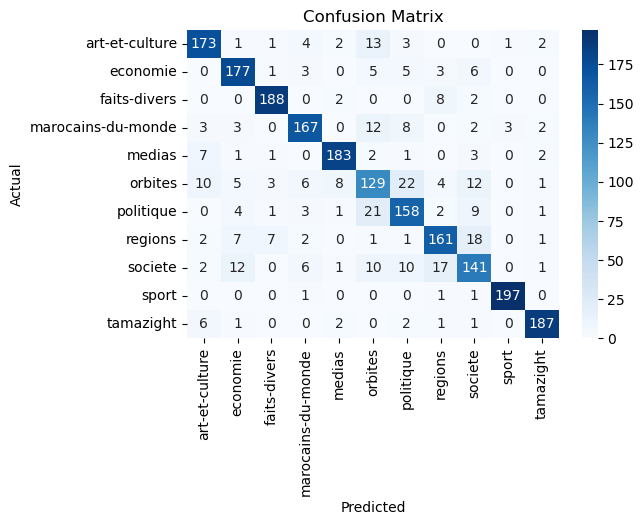

In [21]:
plot_confustion_matrix(y_test, y_pred_tf_svc)

## Multinomial NB

In [22]:
tf_mnb = MultinomialNB()
tf_mnb.fit(tf_X_train,y_train)

y_pred_tf_mnb = tf_mnb.predict(tf_X_test)
print(classification_report(y_test, y_pred_tf_mnb))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       200
           1       0.88      0.76      0.82       200
           2       0.96      0.83      0.89       200
           3       0.85      0.61      0.71       200
           4       0.38      0.95      0.55       200
           5       0.58      0.67      0.62       200
           6       0.80      0.66      0.73       200
           7       0.91      0.57      0.70       200
           8       0.76      0.59      0.66       200
           9       0.99      0.95      0.97       200
          10       0.93      0.85      0.89       200

    accuracy                           0.74      2200
   macro avg       0.81      0.74      0.76      2200
weighted avg       0.81      0.74      0.76      2200



Multinomial NB can also predict the "sport" (9) topic well, as it has the highest percision and recall of 0.99 and 0.95 respectively. 
- The high precision means that when the model predicts stories as the topic "sports", it is 99% likely to be correct. 
- The high recall means that when the model identifies stories related to the topic "sports", it captures approximately 95% of all actual stories that truly belong to the 'sports' category. 

Multinomial NB had a very low precision of 0.38 for the topic "medias" (4). When it predicts that a story belongs to "medias", it is 62% likely to get it wrong.

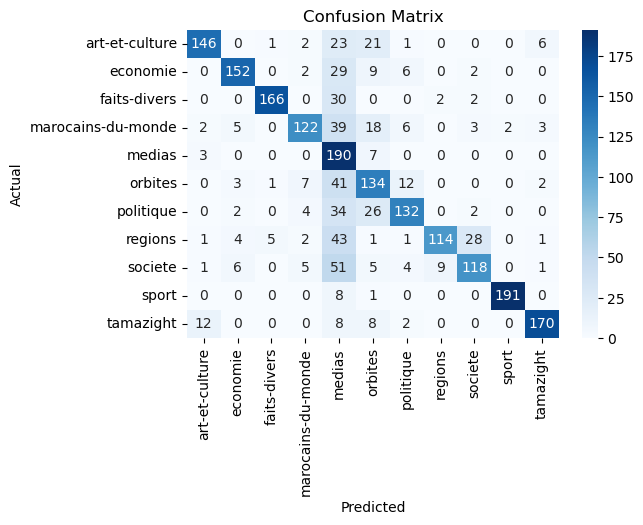

In [23]:
plot_confustion_matrix(y_test, y_pred_tf_mnb)

## Random Forest

In [40]:
tf_rf = RandomForestClassifier(random_state=42)
tf_rf.fit(tf_X_train,y_train)

y_pred_tf_rf = tf_rf.predict(tf_X_test)
print(classification_report(y_test, y_pred_tf_rf))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       200
           1       0.70      0.88      0.78       200
           2       0.88      0.95      0.91       200
           3       0.79      0.77      0.78       200
           4       0.87      0.78      0.82       200
           5       0.73      0.54      0.62       200
           6       0.65      0.78      0.71       200
           7       0.78      0.73      0.75       200
           8       0.76      0.55      0.64       200
           9       0.96      0.98      0.97       200
          10       0.89      0.90      0.89       200

    accuracy                           0.79      2200
   macro avg       0.79      0.79      0.79      2200
weighted avg       0.79      0.79      0.79      2200



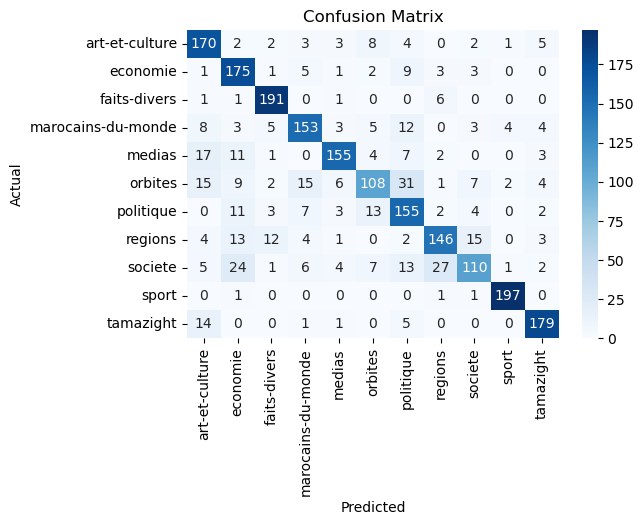

In [25]:
plot_confustion_matrix(y_test, y_pred_tf_rf)

## SGDClassifier

In [26]:
tf_sgd = SGDClassifier(random_state=42)
tf_sgd.fit(tf_X_train, y_train)

y_pred_tf_sgd = tf_sgd.predict(tf_X_test)
print(classification_report(y_test, y_pred_tf_sgd))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       200
           1       0.84      0.89      0.86       200
           2       0.93      0.94      0.93       200
           3       0.86      0.83      0.85       200
           4       0.90      0.92      0.91       200
           5       0.68      0.65      0.66       200
           6       0.74      0.80      0.77       200
           7       0.80      0.82      0.81       200
           8       0.75      0.67      0.71       200
           9       0.98      0.98      0.98       200
          10       0.95      0.94      0.94       200

    accuracy                           0.85      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.85      0.85      0.85      2200



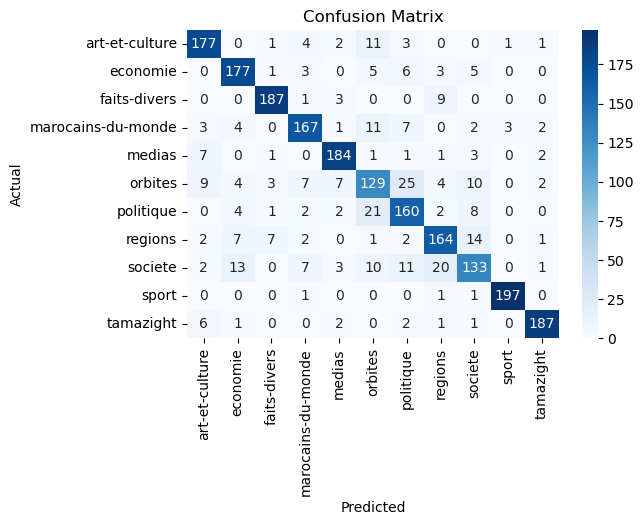

In [27]:
plot_confustion_matrix(y_test, y_pred_tf_sgd)

## Logistic Regression

In [28]:
tf_lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
tf_lr.fit(tf_X_train, y_train)

y_pred_tf_lr = tf_lr.predict(tf_X_test)
print(classification_report(y_test, y_pred_tf_lr))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       200
           1       0.83      0.88      0.85       200
           2       0.94      0.94      0.94       200
           3       0.85      0.84      0.85       200
           4       0.91      0.90      0.90       200
           5       0.64      0.70      0.67       200
           6       0.76      0.76      0.76       200
           7       0.80      0.80      0.80       200
           8       0.73      0.69      0.71       200
           9       0.98      0.98      0.98       200
          10       0.97      0.88      0.92       200

    accuracy                           0.84      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.84      0.84      0.84      2200



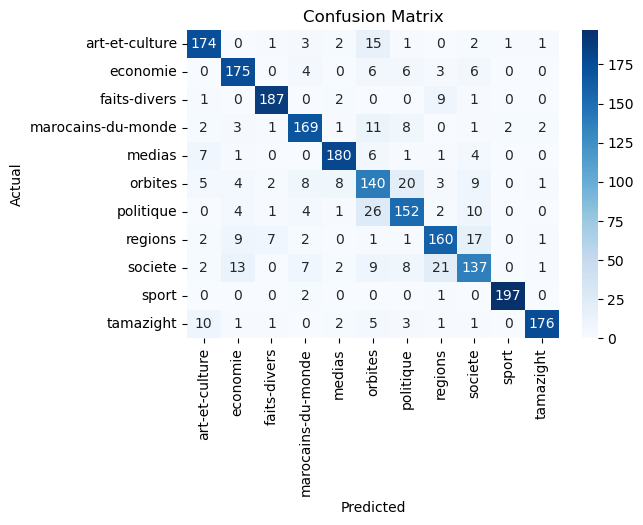

In [29]:
plot_confustion_matrix(y_test, y_pred_tf_lr)

# Models Comparison & Conclusion

All the models struggle a little bit on predicting the topic "orbites" (5) compared to the other topics. 

However, they can all predict the topics "sport" (9) and "tamazight" (10) well (especially "sport").

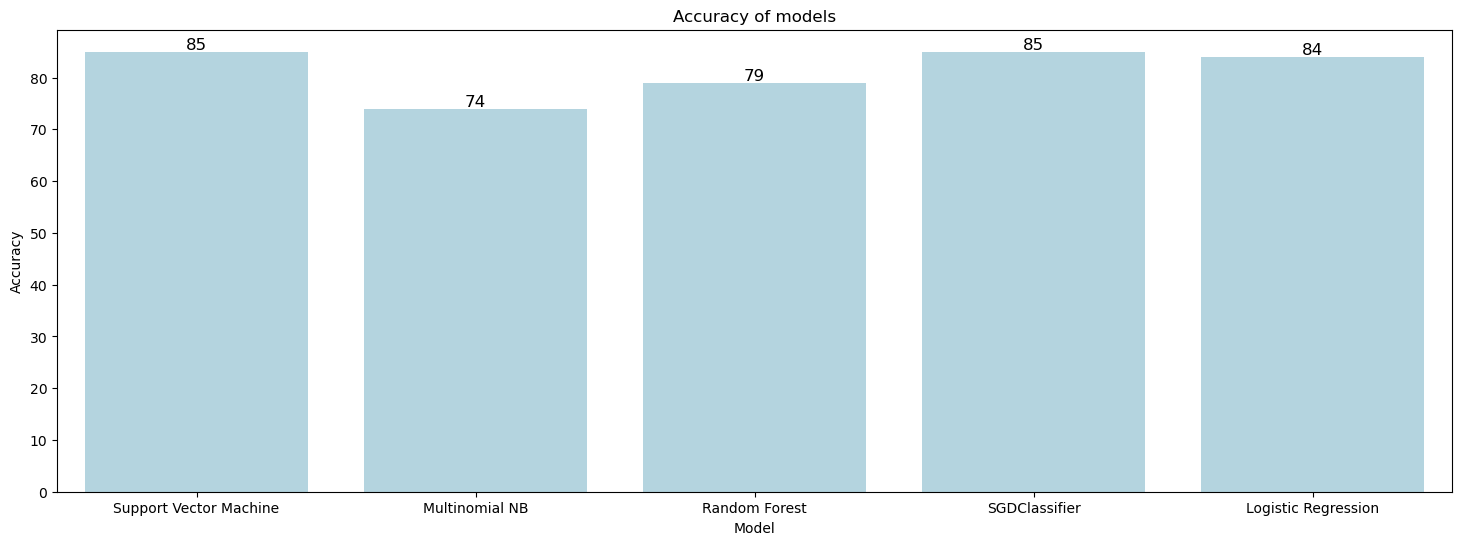

In [41]:
categories = ['Support Vector Machine', 'Multinomial NB', 'Random Forest', 'SGDClassifier', 'Logistic Regression']
values = [85, 74, 79, 85, 84]

fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x=categories, y=values, color='lightblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of models')

for i, v in enumerate(values):
    ax.text(i, v + 0.5, str(v), color='black', ha='center', fontsize=12)

plt.show()

**Support Vector Machine** and **Logistic Regression** have the highest accuracies of **85%**. 

However, the SVM model is able to predict the classes better than LR and generally has higher precision and recall.

Therefore, to conclude, **SVM is the most suitable model**.

# Future Steps to improve the modelling:
- Validation & Grid Search for hyperparameter tuning.
- Try with BOW.
- LSTM and MLP Neural Nets.
- Look more into taking into account the author of the story.